In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install praw
!pip install sentencepiece
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.3 MB/s eta 0:00:00


In [3]:
import os
import sys
import pandas as pd
import praw
sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/aita_new/')
from redditConfig import *
from datetime import datetime
import random
import sentencepiece
from transformers import (BigBirdForSequenceClassification, BigBirdTokenizer
                          , Trainer, TrainingArguments)
from datasets import load_metric
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


In [46]:
# set user defined vars

# paths
main_path = '/content/gdrive/MyDrive/Colab Notebooks/aita_new/'
model_path = os.path.join(main_path,'saved_models/','fullModel')
monitor_sheet_path = os.path.join(main_path,'monitor_sheets')
monitor_archive_path = os.path.join(monitor_sheet_path,'archive')

overwrite_day = True

n_posts = 1000


In [47]:
# create monitor_sheet_path folder if it does not already exist
# Check if the directory exists
if not os.path.exists(monitor_sheet_path):
    # Create the directory
    os.makedirs(monitor_sheet_path)

# Check if the directory exists
if not os.path.exists(monitor_archive_path):
    # Create the directory
    os.makedirs(monitor_archive_path)


In [48]:
  YTA_strings = ['ASSHOLE','YTA',"YOU'RE THE ASSHOLE"]
  NTA_strings = ['NOT THE A-HOLE','NOT THE ASSHOLE','NTA']

In [49]:
today = datetime.today().strftime('%m-%d-%Y')
# Authenticate
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Get the subreddit
subreddit = reddit.subreddit(SUBREDDIT_NAME)


# Fetch new posts
new_posts = subreddit.new(limit=n_posts)

# Clear lists and counts
titles_and_texts = []
flairs = []
dates = []
titles = []
YTA_count = 0
NTA_count = 0
post_count = 0
# Extract post data and store in lists
for post in new_posts:

  post_count += 1

  # only get posts with a flair, so we are making prospective
  # predictions
  if not post.link_flair_text:
    continue
  if not post.link_flair_text.upper() in NTA_strings + YTA_strings:
    continue

  # remove posts that are unusually short or long, as these may not be
  # actual AITA posts, or may have been deleted or edited by OP
  if 200 >= len(post.selftext) >= 6500:
    continue

  if post.link_flair_text.upper() in YTA_strings:
    YTA_count += 1
  elif post.link_flair_text.upper() in NTA_strings:
    NTA_count += 1

  post_date = datetime.utcfromtimestamp(post.created_utc).strftime('%m-%d-%Y')

  combined_text = post.title + ' ' + post.selftext  # Combine title and text
  titles_and_texts.append(combined_text)
  titles.append(post.title)
  flairs.append(post.link_flair_text)
  dates.append(post_date)

# import pprint
# print(post.title)
# pprint.pprint(vars(post))
print(f'Got {YTA_count} YTAs and {NTA_count} NTAs after going through ')
print(f'{post_count} posts.')


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Got 135 YTAs and 551 NTAs after going through 
983 posts.


In [50]:
# create df with combined_text and flairs and dates as columns
post_df = pd.DataFrame({
    'combined_text': titles_and_texts,
    'outcome_str': flairs,
    'dates': dates,
})


def code_outcome(outcome):
  YTA_strings = ['ASSHOLE','YTA',"YOU'RE THE ASSHOLE"]
  NTA_strings = ['NOT THE A-HOLE','NOT THE ASSHOLE','NTA']
  ESH_strings = [
      'EVERYONE SUCKS','ESH','EVERBODY SUCKS','EVERYONE SUCKS HERE'
      , 'EVERYBODY SUCKS HERE'
      ]
  info_strings = ['NOT ENOUGH INFO', 'NEI', 'NOT ENOUGH INFO HERE']
  if outcome:
    if outcome.upper() in YTA_strings:
      return 1
    elif outcome.upper() in NTA_strings:
      return 0
    elif outcome.upper() in ESH_strings:
      return 2
    elif outcome.upper() in info_strings:
      return 3


post_df['outcome'] = post_df['outcome_str'].apply(code_outcome)

print(post_df)

                                         combined_text     outcome_str  \
0    WIBTA if I decided I was done with all of the ...  Not the A-hole   
1    AITA if I shouted at my guilt trippy ex whose ...  Not the A-hole   
2    AITA For Moving Out? I (20f) and my mother hav...  Not the A-hole   
3    AITA for calling my mom a snake \n\nMy mom has...  Not the A-hole   
4    AITA for not letting my friend release a song?...  Not the A-hole   
..                                                 ...             ...   
681  AITA for siding with my dad about staying with...  Not the A-hole   
682  AITA for calling my fiance 'low life scum' aft...  Not the A-hole   
683  AITA for telling my sister that her life is my...         Asshole   
684  WIBTA - If I ask my neighbor to abide by the t...  Not the A-hole   
685  AITA or just rude for not accepting a lift?  I...  Not the A-hole   

          dates  outcome  
0    03-01-2024        0  
1    03-01-2024        0  
2    03-01-2024        0  
3  

In [51]:
'''
takes categorical column of a df, outputs table of counts and percentages
for each category
'''
def count_table(df_col,digits=1):
  return pd.concat(
      [df_col.value_counts()
      ,df_col.value_counts(normalize=True).mul(100).round(digits).astype(str)+'%']
      ,axis=1)


print('Outcome Distribution:')
display(count_table(post_df['outcome']))
print('')
print(f'Post dates range from {post_df["dates"].min()} to '
  f'{post_df["dates"].max()}')

Outcome Distribution:


,outcome,outcome
0,551,80.3%
1,135,19.7%



Post dates range from 02-25-2024 to 03-01-2024


In [52]:

# for each value in post_df["outcome"] randomly select rows with that value

'''
for each value in df["colname"], randomly select N rows and subset to those rows
'''
def random_n_by_cat(df,df_colname,n):
  return (df.groupby(df_colname)
              .apply(lambda x: x.sample(n=n))
              .reset_index(drop=True))

balanced_posts_df = random_n_by_cat(post_df,"outcome",YTA_count)

In [53]:
print('Outcome Distribution:')
display(count_table(balanced_posts_df['outcome']))
print('')

display(balanced_posts_df)


Outcome Distribution:


,outcome,outcome
0,135,50.0%
1,135,50.0%


,combined_text,outcome_str,dates,outcome
0,AITA for not enjoying my boyfriends suprise to...,Not the A-hole,02-29-2024,0
1,"AITA, for not wanting to drop what I was doing...",Not the A-hole,02-28-2024,0
2,WIBTA for asking my friend to let me use my mo...,Not the A-hole,02-29-2024,0
3,AITA for being frustrated my wife is changing ...,Not the A-hole,02-26-2024,0
4,AITA for answering honestly about my wife's gl...,Not the A-hole,02-29-2024,0
...,...,...,...,...
265,AITA for wanting my best friend at my daughter...,Asshole,02-27-2024,1
266,AITA for keeping my fiancé's old wedding photo...,Asshole,02-26-2024,1
267,AITA For Having My Baby Shower on a Weekday Mo...,Asshole,02-29-2024,1
268,AITA for pushing back on one of my FIL's favor...,Asshole,02-27-2024,1


In [54]:
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')

post_tokens = tokenizer(np.array(balanced_posts_df['combined_text']).tolist(), padding=True, truncation=True, return_tensors="pt")

to_predict_dataset = TensorDataset(post_tokens['input_ids'], post_tokens['attention_mask'])

In [55]:
def assign_torch_device(quiet=False):
  if torch.cuda.is_available():
      device = torch.device("cuda")  # GPU
      if not quiet:
        print("GPU available. Using GPU.")
  else:
      device = torch.device("cpu")  # CPU
      if not quiet:
        print("GPU is not available. Using CPU.")
  return device

device = assign_torch_device()

GPU available. Using GPU.


In [56]:
print(model_path)

model_loaded = (BigBirdForSequenceClassification.from_pretrained(model_path)
              .to(device))

/content/gdrive/MyDrive/Colab Notebooks/aita_new/saved_models/fullModel


In [57]:
training_args = TrainingArguments("test_trainer",report_to='none')

In [58]:
def data_collector(features):
    batch = {}
    batch['input_ids'] = torch.stack([f[0] for f in features])
    batch['attention_mask'] = torch.stack([f[1] for f in features])
    return batch

# Initialize Trainer
trainer = Trainer(
    model=model_loaded,
    args=training_args,
    data_collator=data_collector,
)


In [59]:
pred = trainer.predict(to_predict_dataset)

In [60]:
logits_list = pred.predictions.reshape(-1)
bin_pred_list = (pred.predictions > 0.5).astype(np.int32).reshape(-1)

In [61]:
# add logits_list and bin_pred_list to balanced_posts_df
preds_df = balanced_posts_df

preds_df['logits'] = logits_list
preds_df['predictions'] = bin_pred_list

#using prob_df, generate a new column, accurate based on predictions
# and label_ids
preds_df['accurate'] = (
    preds_df['predictions'] == preds_df['outcome']).astype(int)

display(preds_df)

,combined_text,outcome_str,dates,outcome,logits,predictions,accurate
0,AITA for not enjoying my boyfriends suprise to...,Not the A-hole,02-29-2024,0,0.121159,0,1
1,"AITA, for not wanting to drop what I was doing...",Not the A-hole,02-28-2024,0,0.029936,0,1
2,WIBTA for asking my friend to let me use my mo...,Not the A-hole,02-29-2024,0,0.092504,0,1
3,AITA for being frustrated my wife is changing ...,Not the A-hole,02-26-2024,0,0.919343,1,0
4,AITA for answering honestly about my wife's gl...,Not the A-hole,02-29-2024,0,1.060227,1,0
...,...,...,...,...,...,...,...
265,AITA for wanting my best friend at my daughter...,Asshole,02-27-2024,1,1.058998,1,1
266,AITA for keeping my fiancé's old wedding photo...,Asshole,02-26-2024,1,1.056062,1,1
267,AITA For Having My Baby Shower on a Weekday Mo...,Asshole,02-29-2024,1,0.944428,1,1
268,AITA for pushing back on one of my FIL's favor...,Asshole,02-27-2024,1,1.054014,1,1


In [62]:
# use outcome and predictions in preds_df to make a confusion matrix
def confusion_m(df, labels_col, predictions_col):
  return pd.crosstab(
      df[labels_col]
      , df[predictions_col]
      , rownames=['Actual']
      , colnames=['Predicted'])

matrix = confusion_m(preds_df, 'outcome', 'predictions')
print(matrix)

Predicted   0   1
Actual           
0          95  40
1          41  94


In [63]:
# get percent accurate using preds_df['accurate']

class binomial_stats:
  def __init__(self,df_col):

    self.df_col = df_col

    self._success = self.df_col.sum()

    self._n = len(df_col)

    self._rate = self._success/self._n

    self._sd_prop = np.sqrt(self._rate*(1-self._rate))

    self._sd_n = np.sqrt(self._rate*(1-self._rate)*self._n)

    self._se = np.sqrt(self._rate*(1-self._rate)/self._n)

  @property
  def success(self):
      return self._success

  @property
  def n(self):
      return self._n

  @property
  def rate(self):
      return self._rate

  @property
  def sd_prop(self):
      return self._sd_prop

  @property
  def sd_n(self):
      return self._sd_n

  @property
  def se(self):
      return self._se

acc_binom = binomial_stats(preds_df['accurate'])

YTA_acc_binom = binomial_stats(preds_df[preds_df['outcome'] == 1]['accurate'])

NTA_acc_binom = binomial_stats(preds_df[preds_df['outcome'] == 0]['accurate'])

# create binom df
new_monitor_dict = {
    'date':today
    , 'outcome_type':['Total','YTA','NTA']
    , 'success':[acc_binom.success,YTA_acc_binom.success,NTA_acc_binom.success]
    , 'n':[acc_binom.n,YTA_acc_binom.n,NTA_acc_binom.n]
    , 'rate':[acc_binom.rate,YTA_acc_binom.rate,NTA_acc_binom.rate]
    , 'se':[acc_binom.se,YTA_acc_binom.se,NTA_acc_binom.se]
    , 'min_post_date':[
        post_df["dates"].min(),post_df["dates"].min(),post_df["dates"].min()]
    , 'max_post_date':[
        post_df["dates"].max(),post_df["dates"].max(),post_df["dates"].max()]
}

new_monitor_df = pd.DataFrame.from_dict(new_monitor_dict)

for index, row in new_monitor_df.iterrows():
  print(
      f'{row["outcome_type"]} Accuracy Rate: {row["rate"]:.1%}'
      f' SE: {row["se"]:.1%}'
      )




Total Accuracy Rate: 70.0% SE: 2.8%
YTA Accuracy Rate: 69.6% SE: 4.0%
NTA Accuracy Rate: 70.4% SE: 3.9%


In [71]:
#read in current_monitor_df from csv

current_monitor_csv = os.path.join(monitor_sheet_path, "current_monitor.csv")
if os.path.exists(current_monitor_csv):

  current_monitor_df = pd.read_csv(current_monitor_csv)

  if overwrite_day == True and today in current_monitor_df['date'].values:

    current_monitor_df = current_monitor_df[current_monitor_df['date'] != today]

  if not today in current_monitor_df['date'].values:

    new_current_monitor_df = pd.concat([current_monitor_df,new_monitor_df])

    # create an archive copy
    new_current_monitor_df.to_csv(os.path.join(
      monitor_archive_path, f'monitor_{today}.csv'), index=False)

    # save as current
    new_current_monitor_df.to_csv(current_monitor_csv, index=False)

  else:

    print(f"{current_monitor_csv} already contains entries with today's date")
    print(f"sheet will not be updated, current predictions will not be archived")


else:
  new_current_monitor_df = new_monitor_df

  # create an archive copy
  new_current_monitor_df.to_csv(os.path.join(
      monitor_archive_path, f'monitor_{today}.csv'), index=False)

  # save as current
  new_current_monitor_df.to_csv(current_monitor_csv, index=False)



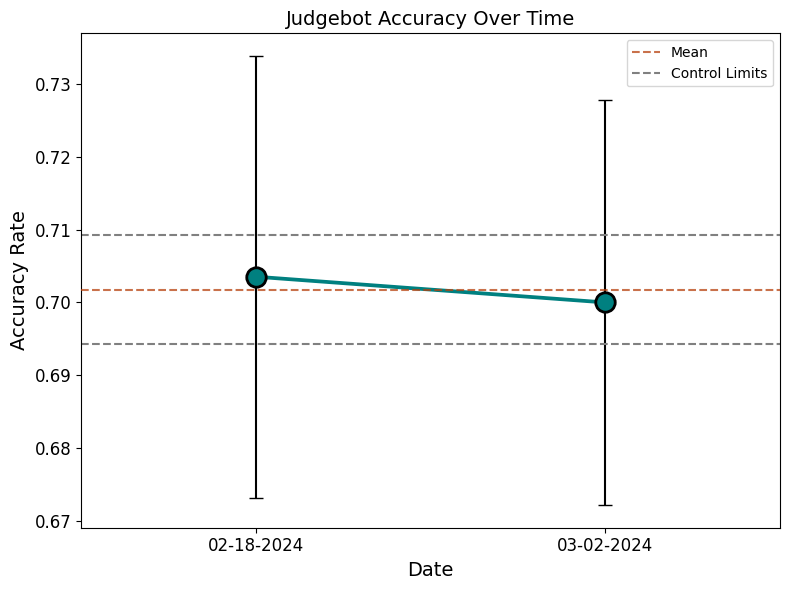

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Filter data
total_data = new_current_monitor_df[new_current_monitor_df['outcome_type'] == 'Total']

# Calculate the mean proportion
mean_proportion = total_data['rate'].mean()

# Calculate the standard deviation of the proportion
std_dev_proportion = total_data['rate'].std()

# Calculate the control limits (assuming normal approximation)
UCL = mean_proportion + 3 * std_dev_proportion
LCL = mean_proportion - 3 * std_dev_proportion

# Create plot
plt.figure(figsize=(8, 6))

# Plot data with error bars
plt.errorbar(total_data['date'], total_data['rate'], yerr=total_data['se'],
             capsize=5, color='black', zorder=1)

# Plot the mean line
plt.axhline(y=mean_proportion, color='#B7410E', linestyle='--', label='Mean'
            , zorder=5, alpha=.75)

# Plot the control limits
plt.axhline(y=UCL, color='gray', linestyle='--', label='Control Limits', zorder=2)
plt.axhline(y=LCL, color='gray', linestyle='--', label='_Hidden label', zorder=2)


# Plot data points
sns.pointplot(x='date', y='rate', data=total_data, color='teal', markers='o',
              linestyles='-', markeredgecolor='black', zorder=4, markersize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Accuracy Rate', fontsize=14)
plt.title('Judgebot Accuracy Over Time', fontsize=14)

# Show legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()